## Import modules

In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import math
import time
import warnings
warnings.filterwarnings('ignore')

## Define specialized variables

In [2]:
match_week_stage = math.floor((3/4)*38)
print(match_week_stage)

28


## Obtain League and shots data from Statsbomb

In [3]:
competitions = sb.competitions()

In [4]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [5]:
PremierLeague = sb.matches(competition_id=2, season_id=27)
PremierLeague.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3754058,2016-01-02,16:00:00.000,England - Premier League,2015/2016,Leicester City,AFC Bournemouth,0,0,available,...,2021-06-12T16:17:31.694,20,Regular Season,King Power Stadium,Andre Marriner,Claudio Ranieri,Eddie Howe,1.1.0,2,2
1,3754245,2015-10-17,16:00:00.000,England - Premier League,2015/2016,West Bromwich Albion,Sunderland,1,0,available,...,2021-06-13T16:17:31.694,9,Regular Season,The Hawthorns,Martin Atkinson,Tony Pulis,Sam Allardyce,1.1.0,2,2
2,3754136,2015-12-19,18:30:00.000,England - Premier League,2015/2016,Newcastle United,Aston Villa,1,1,available,...,2021-06-13T16:17:31.694,17,Regular Season,St. James'' Park,Martin Atkinson,Steve McClaren,Rémi Garde,1.1.0,2,2
3,3754037,2016-04-30,16:00:00.000,England - Premier League,2015/2016,Everton,AFC Bournemouth,2,1,available,...,2021-06-12T16:17:31.694,36,Regular Season,Goodison Park,Neil Swarbrick,Roberto Martínez Montoliú,Eddie Howe,1.1.0,2,2
4,3754039,2016-02-13,16:00:00.000,England - Premier League,2015/2016,Crystal Palace,Watford,1,2,available,...,2021-06-12T16:17:31.694,26,Regular Season,Selhurst Park,Robert Madley,Alan Pardew,Enrique Sánchez Flores,1.1.0,2,2


### Get idea of column names for league matches

In [6]:
PremierLeague.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [7]:
print(pd.unique(PremierLeague['home_team']))

['Leicester City' 'West Bromwich Albion' 'Newcastle United' 'Everton'
 'Crystal Palace' 'Arsenal' 'Tottenham Hotspur' 'Sunderland' 'Aston Villa'
 'Liverpool' 'Stoke City' 'Manchester United' 'AFC Bournemouth'
 'Swansea City' 'Southampton' 'Norwich City' 'Chelsea' 'Watford'
 'Manchester City' 'West Ham United']


### Get idea of column names for match events

In [8]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [9]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome', 'under_pressure']

## Obtain dataframe of all shots up to our matchweek stage

In [10]:
Premier_League_shots_df = pd.DataFrame(columns=relevant_attributes)

In [11]:
start = time.time()
for match in PremierLeague[PremierLeague['match_week']<=match_week_stage]['match_id']:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    Premier_League_shots_df = pd.concat([Premier_League_shots_df, relevant_match_df], ignore_index=True)

Premier_League_shots_df['shot_outcome'] = Premier_League_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

Premier_League_shots_df['distance'] = Premier_League_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
Premier_League_shots_df['shot_angle'] = Premier_League_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
Premier_League_shots_df

script run time: 3.6830281456311544 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,under_pressure,distance,shot_angle
0,1,33,AFC Bournemouth,0.020838,Junior Stanislas,Left Midfield,"[107.1, 26.6]",Right Foot,"[109.7, 30.1]",NaN,Normal,Open Play,Shot,0,NaN,18.600269,0.804407
1,4,23,AFC Bournemouth,0.034462,Joshua King,Center Forward,"[113.7, 54.0]",Right Foot,"[114.5, 52.6]",NaN,Normal,Open Play,Shot,0,NaN,15.352199,1.147942
2,9,20,Leicester City,0.035481,Riyad Mahrez,Right Midfield,"[115.7, 50.5]",Left Foot,"[120.0, 43.3, 3.6]",True,Overhead Kick,Open Play,Shot,0,True,11.346365,1.182107
3,13,11,AFC Bournemouth,0.383711,Joshua King,Center Forward,"[113.9, 38.6]",Head,"[120.0, 46.0, 1.2]",NaN,Normal,Open Play,Shot,0,NaN,6.258594,0.225601
4,25,47,Leicester City,0.036740,José Leonardo Ulloa,Right Center Forward,"[96.7, 47.2]",Right Foot,"[103.9, 40.1]",NaN,Half Volley,Open Play,Shot,0,NaN,24.387087,0.299705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,72,28,Swansea City,0.115056,Wayne Routledge,Left Wing,"[109.1, 29.8]",Right Foot,"[115.7, 37.8, 0.0]",NaN,Normal,Open Play,Shot,0,NaN,14.928161,0.752235
7229,74,15,Chelsea,0.126068,Eden Hazard,Left Wing,"[114.6, 51.4]",Right Foot,"[117.8, 45.3, 1.2]",NaN,Normal,Open Play,Shot,0,NaN,12.614278,1.128422
7230,75,6,Chelsea,0.023097,Branislav Ivanović,Right Back,"[98.3, 56.9]",Right Foot,"[104.8, 51.2]",NaN,Normal,Open Play,Shot,0,NaN,27.504545,0.661681
7231,80,12,Swansea City,0.029767,André Ayew Pelé,Right Wing,"[102.9, 58.1]",Left Foot,"[116.9, 43.6, 2.1]",NaN,Normal,Open Play,Shot,0,NaN,24.900201,0.813800


## Describing the Data

In [12]:
Premier_League_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,7233.000000,7233.000000,7233.000000,7233.000000
mean,0.097865,0.097608,19.151255,0.482173
std,0.135491,0.296805,8.368381,0.322475
min,0.000180,0.000000,0.921954,0.000000
25%,0.028571,0.000000,12.185237,0.213205
50%,0.052837,0.000000,18.883061,0.445712
75%,0.100907,0.000000,25.423218,0.710648
max,0.983099,1.000000,86.137100,1.565668


In [13]:
Premier_League_shots_df = Premier_League_shots_df[Premier_League_shots_df.shot_type != 'Corner']

In [14]:
Premier_League_shots_df['shot_outcome'].value_counts()

shot_outcome
0    6527
1     705
Name: count, dtype: int64

In [15]:
Premier_League_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg', 'xg_overperformance'])
for team in pd.unique(Premier_League_shots_df['team']):
    shot_sum = Premier_League_shots_df['team'].value_counts()[team]
    goal_sum = sum(Premier_League_shots_df[Premier_League_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(Premier_League_shots_df[Premier_League_shots_df['team']==team]['shot_statsbomb_xg'])
    xg_overperformance = goal_sum - statsbomb_xg_sum
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum, 'xg_overperformance': xg_overperformance})
    Premier_League_team_summary_df.loc[len(Premier_League_team_summary_df)]=new_row
Premier_League_team_summary_df = Premier_League_team_summary_df.sort_values(by=['goals'], ascending=False)
totals_row = pd.Series({'team': 'Totals',
                        'shots': sum(Premier_League_team_summary_df['shots']),
                        'goals': sum(Premier_League_team_summary_df['goals']),
                        'statsbomb_xg': sum(Premier_League_team_summary_df['statsbomb_xg']),
                        'xg_overperformance': sum(Premier_League_team_summary_df['xg_overperformance'])})
Premier_League_team_summary_df.loc[len(Premier_League_team_summary_df)]=totals_row
Premier_League_team_summary_df

,team,shots,goals,statsbomb_xg,xg_overperformance
1,Leicester City,376,50,47.141306,2.858694
19,Tottenham Hotspur,470,49,43.863796,5.136204
8,Manchester City,463,49,46.409758,2.590242
17,Everton,387,46,39.870778,6.129222
10,Liverpool,474,44,42.483587,1.516413
14,West Ham United,380,42,35.480574,6.519426
18,Arsenal,438,42,49.135135,-7.135135
13,Chelsea,392,38,39.162635,-1.162635
12,Manchester United,322,35,32.241398,2.758602
16,Southampton,373,33,36.837833,-3.837833


In [16]:
type(Premier_League_team_summary_df['statsbomb_xg'][0])

float

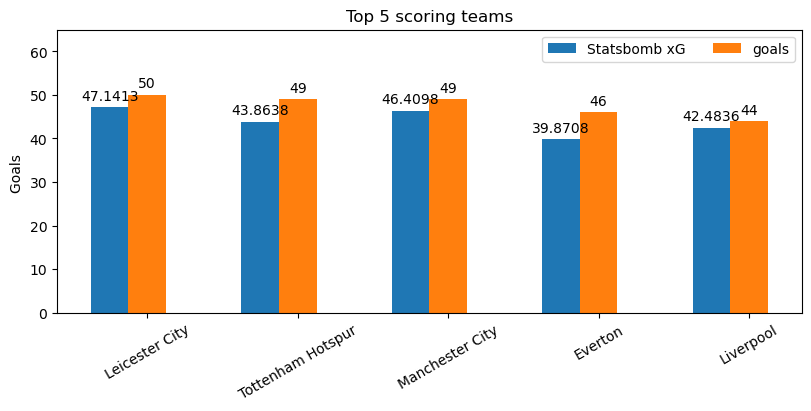

In [17]:
teams = Premier_League_team_summary_df['team'][0:5]
team_goals = {
    'Statsbomb xG': Premier_League_team_summary_df['statsbomb_xg'][0:5].round(),
    'goals': Premier_League_team_summary_df['goals'][0:5].round(),
}

x = np.arange(len(teams))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8,4))

for attribute, measurement in team_goals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Goals ')
ax.set_title('Top 5 scoring teams')
ax.set_xticks(x + width, teams)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 65)
ax.tick_params(axis='x', rotation=30)
plt.show()

In [18]:
Premier_League_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'under_pressure',
       'distance', 'shot_angle'],
      dtype='object')

## Split training and test data, train model and define functions

In [19]:
cap_x_df, y_df = pd.concat([Premier_League_shots_df.iloc[:,:-4], Premier_League_shots_df.iloc[:,-3:]], axis=1),Premier_League_shots_df.iloc[:,-4].to_frame()

In [20]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [21]:
target_attr = 'shot_outcome'

In [22]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [23]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'under_pressure']

In [112]:
for attr in nominal_attrs:
    print(attr)
    print(pd.unique(cap_x_df[attr]))
    print(cap_x_df[attr].value_counts())

shot_technique
['Normal' 'Overhead Kick' 'Half Volley' 'Volley' 'Diving Header'
 'Backheel' 'Lob']
shot_technique
Normal           5676
Half Volley       944
Volley            457
Overhead Kick      45
Lob                40
Diving Header      38
Backheel           32
Name: count, dtype: int64
shot_type
['Open Play' 'Penalty' 'Free Kick']
shot_type
Open Play    6885
Free Kick     284
Penalty        63
Name: count, dtype: int64
shot_body_part
['Right Foot' 'Left Foot' 'Head' 'Other']
shot_body_part
Right Foot    3922
Left Foot     2132
Head          1163
Other           15
Name: count, dtype: int64
position
['Left Midfield' 'Center Forward' 'Right Midfield' 'Right Center Forward'
 'Left Center Forward' 'Right Center Midfield' 'Right Center Back'
 'Right Back' 'Left Defensive Midfield' 'Left Center Back' 'Left Back'
 'Left Center Midfield' 'Center Attacking Midfield' 'Right Wing'
 'Center Defensive Midfield' 'Right Defensive Midfield' 'Left Wing'
 'Left Wing Back' 'Right Wing Back' 'Left 

In [25]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [26]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value=False)),
               ('target_encoder', TargetEncoder(target_type='auto', random_state=42)),
               #("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [27]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

### The function below will be used to compare our models to the statsbomb model

In [95]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.figure()
    df = pd.DataFrame({'model1':model1,'model2':model2,'outcome':outcome})
    no_goal = df[df['outcome']==0]
    plt.scatter(no_goal['model1'],no_goal['model2'], label='no goal', color='blue', alpha=0.6, edgecolors='none')
    goal = df[df['outcome']==1]
    plt.scatter(goal['model1'],goal['model2'], label='goal', color='orange', alpha=0.9, edgecolors='none')
    #plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.legend()
    plt.title("Comparison of " + model1_name + " to " + model2_name)
    z = np.polyfit(model1, model2,1)
    #z = np.polyfit(df['model1'], df['model2'],1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    #plt.plot(df['model1'], p(df['model1']),"r--")
    print(model1_name)
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

## Train our estimators

LogisticRegression
y=0.98x+0.00
$R^2$= 0.30426427905312237
SGDClassifier
y=0.80x+0.01
$R^2$= 0.27383088107898323
RandomForestClassifier
y=0.68x+0.03
$R^2$= 0.5265145963060569
GradientBoostingClassifier
y=0.89x+0.01
$R^2$= 0.5795649021777628
DecisionTreeClassifier
y=0.18x+0.08
$R^2$= 0.16537441310229817


,shots,goals,statsbomb_xg,LogisticRegression,SGDClassifier,RandomForestClassifier,GradientBoostingClassifier,DecisionTreeClassifier
0,5785,564,566.810458,562.510579,609.327771,565.95,549.874004,584.0


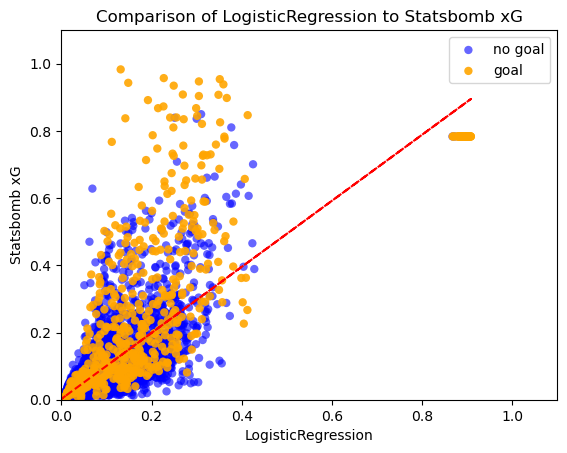

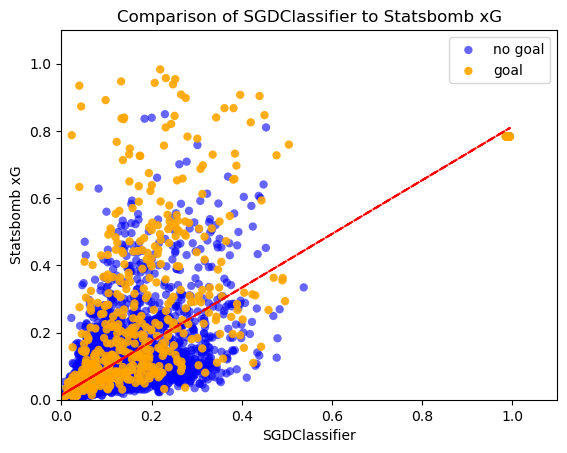

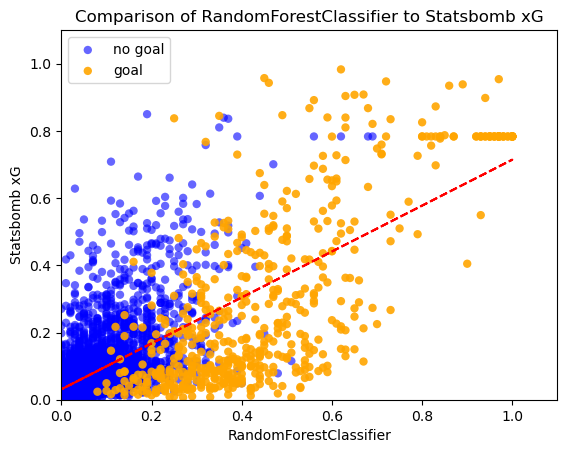

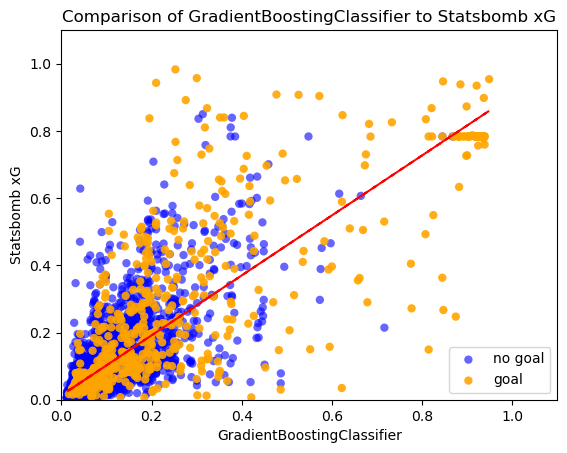

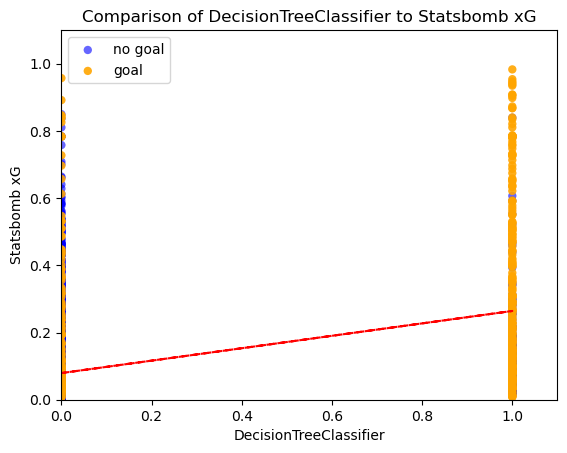

In [96]:
estimator_names = ['LogisticRegression', 'SGDClassifier', 'RandomForestClassifier', 
                  'GradientBoostingClassifier', 'DecisionTreeClassifier']

estimator_list = [LogisticRegression(), SGDClassifier(loss='log_loss'), 
                  RandomForestClassifier(criterion='log_loss'), GradientBoostingClassifier(loss='log_loss'),
                 DecisionTreeClassifier(criterion='log_loss')]
trained_estimator_dict = {}
#model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg']
model_summary = {}
model_summary['shots'] = [len(train_y_df[target_attr])]
model_summary['goals'] = [train_y_df[target_attr].value_counts()[1]]
model_summary['statsbomb_xg'] = [sum(train_cap_x_df['shot_statsbomb_xg'])]
for estimator_name, estimator in zip(estimator_names, estimator_list):
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
    trained_estimator_dict[estimator_name] = composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())
    predictions = trained_estimator_dict[estimator_name].predict_proba(train_cap_x_df)[:,1]
    SBModel = train_cap_x_df['shot_statsbomb_xg']
    shot_outcome = train_y_df[target_attr]
    model_summary[estimator_name] = [sum(predictions)]
    plot_comparison(predictions, estimator_name, SBModel, 'Statsbomb xG', shot_outcome)
#print(pd.DataFrame(model_summary))
pd.DataFrame.from_dict(model_summary)

## Select Best Model and examine Permutation Importance

In [97]:
best_model_name = 'GradientBoostingClassifier'
best_model = trained_estimator_dict[best_model_name]

In [98]:
feature_importances = permutation_importance(
    best_model, train_cap_x_df, train_y_df.values.ravel())

In [99]:
mean_feature_importances = pd.Series(feature_importances.importances_mean, index=train_cap_x_df.columns)
mean_feature_importances.sort_values(ascending=False)

distance             0.016975
shot_type            0.008747
shot_angle           0.002074
shot_technique       0.002005
shot_body_part       0.001487
minute               0.000795
position             0.000761
under_pressure       0.000415
second               0.000000
team                 0.000000
shot_statsbomb_xg    0.000000
player               0.000000
location             0.000000
shot_end_location    0.000000
type                 0.000000
shot_first_time     -0.000207
dtype: float64

In [100]:
std_feature_importances = pd.Series(feature_importances.importances_std, index=train_cap_x_df.columns)
std_feature_importances

minute               0.000321
second               0.000000
team                 0.000000
shot_statsbomb_xg    0.000000
player               0.000000
position             0.000403
location             0.000000
shot_body_part       0.000520
shot_end_location    0.000000
shot_first_time      0.000202
shot_technique       0.000176
shot_type            0.000730
type                 0.000000
under_pressure       0.000176
distance             0.001305
shot_angle           0.000547
dtype: float64

In [101]:
type(mean_feature_importances)

pandas.core.series.Series

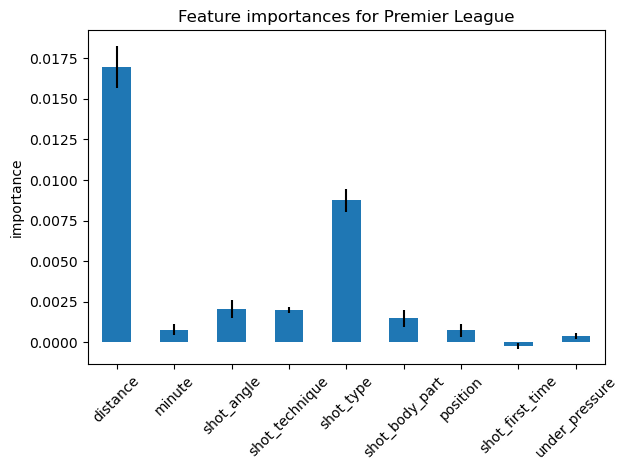

In [102]:
fig, ax = plt.subplots()
#mean_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']].plot.bar(
#    yerr=std_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']], ax=ax)
mean_feature_importances[numerical_attrs+nominal_attrs].plot.bar(
    yerr=std_feature_importances[numerical_attrs+nominal_attrs], ax=ax)
ax.set_title("Feature importances for Premier League")
ax.set_ylabel("importance")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## Evaluate on Test Set

GradientBoostingClassifier
y=0.90x+0.01
$R^2$= 0.5428212847688252


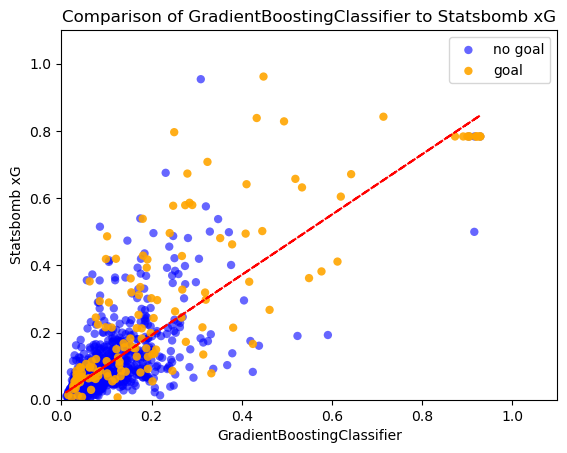

In [103]:
test_predictions = best_model.predict_proba(test_cap_x_df)[:,1]
test_SBModel = test_cap_x_df['shot_statsbomb_xg']
test_shot_outcome = test_y_df[target_attr]
plot_comparison(test_predictions, best_model_name, test_SBModel, 'Statsbomb xG', test_shot_outcome)

## Observe behavior on totality of test set

In [104]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'best_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
best_model_xg = sum(test_predictions)
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'best_model_xg': best_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,best_model_xg
0,1447.0,141.0,141.049764,136.787301


## Examine on Week to Week basis
### Get matches for a particular team

In [105]:
def get_games_for_team(team):
    df = PremierLeague[(PremierLeague['home_team']==team)|(PremierLeague['away_team']==team)]
    df = df.sort_values(by='match_week')
    return df

In [106]:
Chelsea_games = get_games_for_team('Chelsea')
Chelsea_games

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
379,3754078,2015-08-08,18:30:00.000,England - Premier League,2015/2016,Chelsea,Swansea City,2,2,available,...,2021-06-13T16:17:31.694,1,Regular Season,Stamford Bridge,Michael Oliver,José Mario Felix dos Santos Mourinho,Garry Monk,1.1.0,2,2
180,3754066,2015-08-16,17:00:00.000,England - Premier League,2015/2016,Manchester City,Chelsea,3,0,available,...,2021-06-13T16:17:31.694,2,Regular Season,Etihad Stadium,Martin Atkinson,Manuel Luis Pellegrini Ripamonti,José Mario Felix dos Santos Mourinho,1.1.0,2,2
187,3754059,2015-08-23,14:30:00.000,England - Premier League,2015/2016,West Bromwich Albion,Chelsea,2,3,available,...,2021-06-13T16:17:31.694,3,Regular Season,The Hawthorns,Mark Clattenburg,Tony Pulis,José Mario Felix dos Santos Mourinho,1.1.0,2,2
56,3754083,2015-08-29,16:00:00.000,England - Premier League,2015/2016,Chelsea,Crystal Palace,1,2,available,...,2021-06-13T16:17:31.694,4,Regular Season,Stamford Bridge,Craig Pawson,José Mario Felix dos Santos Mourinho,Alan Pardew,1.1.0,2,2
167,3754336,2015-09-12,13:45:00.000,England - Premier League,2015/2016,Everton,Chelsea,3,1,available,...,2021-06-13T16:17:31.694,5,Regular Season,Goodison Park,Andre Marriner,Roberto Martínez Montoliú,José Mario Felix dos Santos Mourinho,1.1.0,2,2
105,3754217,2015-09-19,13:45:00.000,England - Premier League,2015/2016,Chelsea,Arsenal,2,0,available,...,2021-06-13T16:17:31.694,6,Regular Season,Stamford Bridge,Mike Dean,José Mario Felix dos Santos Mourinho,Arsène Wenger,1.1.0,2,2
33,3754001,2015-09-26,18:30:00.000,England - Premier League,2015/2016,Newcastle United,Chelsea,2,2,available,...,2021-06-13T16:17:31.694,7,Regular Season,St. James'' Park,Martin Atkinson,Steve McClaren,José Mario Felix dos Santos Mourinho,1.1.0,2,2
37,3753995,2015-10-03,18:30:00.000,England - Premier League,2015/2016,Chelsea,Southampton,1,3,available,...,2021-06-13T16:17:31.694,8,Regular Season,Stamford Bridge,Robert Madley,José Mario Felix dos Santos Mourinho,Ronald Koeman,1.1.0,2,2
80,3754115,2015-10-17,16:00:00.000,England - Premier League,2015/2016,Chelsea,Aston Villa,2,0,available,...,2021-06-13T16:17:31.694,9,Regular Season,Stamford Bridge,Roger East,José Mario Felix dos Santos Mourinho,Tim Sherwood,1.1.0,2,2
128,3754288,2015-10-24,16:00:00.000,England - Premier League,2015/2016,West Ham United,Chelsea,2,1,available,...,2021-06-13T16:17:31.694,10,Regular Season,Boleyn Ground,Jonathan Moss,Slaven Bilić,José Mario Felix dos Santos Mourinho,1.1.0,2,2


## Examine individual matches
We'll look at a match after matchweek 28, since all the matches before matchweek 28 are what are used to train the model.

In [107]:
next_game_week = 35

In [108]:
match = Chelsea_games[Chelsea_games['match_week']==next_game_week]['match_id'].iloc[0]

In [109]:
def cumulative_sums(array):
    return [sum(array[:i+1]) for i in range(len(array))]

In [110]:
def display_match_results_with_xG(league_df,match, display_shots=False, display_chart=False):
    match_shots_df = pd.DataFrame(columns=relevant_attributes)
    #print(match)
    home_team = league_df[league_df['match_id']==match]['home_team'].values[0]
    home_score = league_df[league_df['match_id']==match]['home_score'].values[0]
    away_team = league_df[league_df['match_id']==match]['away_team'].values[0]
    away_score = league_df[league_df['match_id']==match]['away_score'].values[0]

    match_df = sb.events(match_id=match)
    new_match_df = match_df[relevant_attributes][match_df['type']=='Shot']

    match_shots_df = pd.concat([match_shots_df, new_match_df], ignore_index=True)

    match_shots_df['shot_outcome'] = match_shots_df['shot_outcome'].replace(
        to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
                   'Saved to Post': 0, 'Saved Off Target': 0})

    match_shots_df['distance'] = match_shots_df.apply(lambda row: np.sqrt(np.abs(
        row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
    match_shots_df['shot_angle'] = match_shots_df.apply(
        lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
    match_shots_df = match_shots_df.sort_values(by='minute')
    
    cap_x_df = pd.concat([match_shots_df.iloc[:,:-4], 
                              match_shots_df.iloc[:,-3:]], axis=1)
    
    predictions = best_model.predict_proba(cap_x_df)[:,1]
    predictions_df = pd.DataFrame({'best_model': predictions})
    match_shots_df['best_model']= predictions_df
    
    home_shots_df = match_shots_df[match_shots_df['team']==home_team]
    away_shots_df = match_shots_df[match_shots_df['team']==away_team]

    home_cap_x_df = pd.concat([home_shots_df.iloc[:,:-5], 
                                home_shots_df.iloc[:,-4:]], axis=1)
    away_cap_x_df = pd.concat([away_shots_df.iloc[:,:-5], 
                                away_shots_df.iloc[:,-4:]], axis=1)
    
    home_predictions = home_cap_x_df['best_model']
    away_predictions = away_cap_x_df['best_model']
    
    home_total_best_model_xG = sum(home_predictions)
    away_total_best_model_xG = sum(away_predictions)
    home_statsbomb_xG = sum(home_cap_x_df['shot_statsbomb_xg'])
    away_statsbomb_xG = sum(away_cap_x_df['shot_statsbomb_xg'])
    if display_shots == True:
        display(match_shots_df)
    print("Proposed model")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_total_best_model_xG, home_score, away_score, away_total_best_model_xG, away_team))
    print("statsbomb xG")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_statsbomb_xG, home_score, away_score, away_statsbomb_xG, away_team))
    if display_chart==True:
        home_team_xg = [0]
        away_team_xg = [0]
        home_min = [0]
        away_min = [0]
        for x in range(len(match_shots_df)):
            if match_shots_df['team'][x] == home_team:
                home_team_xg.append(match_shots_df['best_model'][x])
                home_min.append(match_shots_df['minute'][x])
            if match_shots_df['team'][x] == away_team:
                away_team_xg.append(match_shots_df['best_model'][x])
                away_min.append(match_shots_df['minute'][x])
        home_cumulative_xg = cumulative_sums(home_team_xg)
        away_cumulative_xg = cumulative_sums(away_team_xg)

        fig, ax = plt.subplots(figsize= (10,5))
        plt.xticks([0,15,30,45,60,75,90])
        plt.xlabel("minute")
        plt.ylabel("model xG")
        plt.title("Cumulative xG by minute")
        home, = ax.step(x=home_min, y=home_cumulative_xg, label=home_team)
        away, = ax.step(x=away_min, y=away_cumulative_xg, label=away_team)
        ax.legend(handles=[home,away])
    #return match_shots_df

Proposed model
AFC Bournemouth (0.84) 1-4 (1.31) Chelsea
statsbomb xG
AFC Bournemouth (0.75) 1-4 (1.29) Chelsea


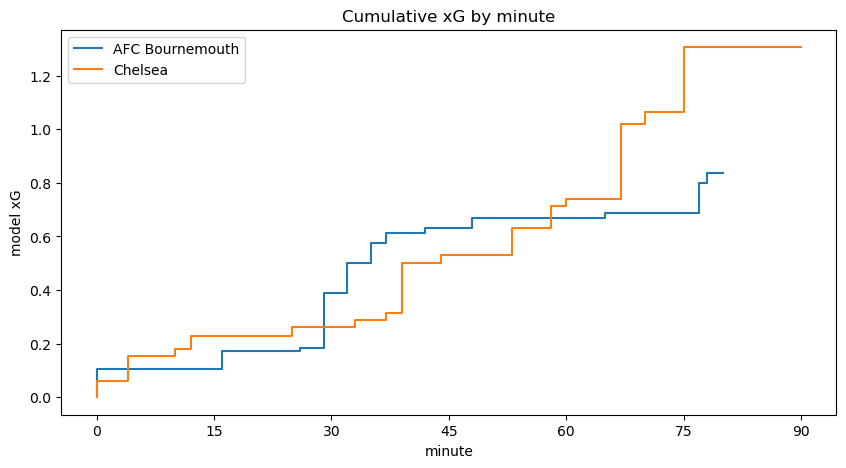

In [111]:
display_match_results_with_xG(Chelsea_games,match, display_shots=False, display_chart=True)